# Online Retail Sales Prediction Modeling

## Timeseries Models

## Regression Models

## Classification Models



### Setup Libraries and Load in Data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

In [2]:
country_mapping_df = pd.read_csv("data/Country Mapping.csv")
region_mapping_df = pd.read_csv("data/region_mapping.csv")
retail_sales_df = pd.read_csv("data/Online Retail.csv")
# Add New Features
retail_sales_df["Cost"] = retail_sales_df["UnitPrice"]*retail_sales_df["Quantity"]
retail_sales_df['alpha-3'] = pd.merge(retail_sales_df,country_mapping_df,how='left',left_on='Country',right_on='country_name').drop(['country_name'],axis=1)['alpha-3']
retail_sales_df = pd.merge(retail_sales_df,region_mapping_df,how='left',on='alpha-3')

In [3]:
retail_sales_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost,alpha-3,name,alpha-2,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,GBR,United Kingdom,GB,826.0,ISO 3166-2:GB,Europe,Northern Europe,NaN,150.0,154.0,NaN
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,GBR,United Kingdom,GB,826.0,ISO 3166-2:GB,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,GBR,United Kingdom,GB,826.0,ISO 3166-2:GB,Europe,Northern Europe,NaN,150.0,154.0,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,GBR,United Kingdom,GB,826.0,ISO 3166-2:GB,Europe,Northern Europe,NaN,150.0,154.0,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,GBR,United Kingdom,GB,826.0,ISO 3166-2:GB,Europe,Northern Europe,NaN,150.0,154.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,FRA,France,FR,250.0,ISO 3166-2:FR,Europe,Western Europe,NaN,150.0,155.0,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,FRA,France,FR,250.0,ISO 3166-2:FR,Europe,Western Europe,NaN,150.0,155.0,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,FRA,France,FR,250.0,ISO 3166-2:FR,Europe,Western Europe,NaN,150.0,155.0,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,FRA,France,FR,250.0,ISO 3166-2:FR,Europe,Western Europe,NaN,150.0,155.0,NaN


In [4]:
#TODO Clean up cancelled orders 
total_invoice_predictions = retail_sales_df[["InvoiceNo","InvoiceDate"]].drop_duplicates()
total_invoice_predictions["InvoiceDate"] = pd.to_datetime(total_invoice_predictions["InvoiceDate"])
total_invoice_predictions

,InvoiceNo,InvoiceDate
0,536365,2010-12-01 08:26:00
7,536366,2010-12-01 08:28:00
9,536367,2010-12-01 08:34:00
21,536368,2010-12-01 08:34:00
25,536369,2010-12-01 08:35:00
...,...,...
541865,581583,2011-12-09 12:23:00
541867,581584,2011-12-09 12:25:00
541869,581585,2011-12-09 12:31:00
541890,581586,2011-12-09 12:49:00


In [5]:
total_invoice_predictions_by_day = total_invoice_predictions.groupby(pd.Grouper(key='InvoiceDate', axis=0,  freq='D')).count().reset_index().rename(columns={"InvoiceNo":"Count"})
total_invoice_predictions_by_day

,InvoiceDate,Count
0,2010-12-01,144
1,2010-12-02,167
2,2010-12-03,108
3,2010-12-04,0
4,2010-12-05,95
...,...,...
369,2011-12-05,151
370,2011-12-06,149
371,2011-12-07,138
372,2011-12-08,145


In [24]:
# Set aside the last 36 days as a validation series
from darts import TimeSeries
mlflow.set_experiment(experiment_id="727021744378495273")
mlflow.autolog()
series = TimeSeries.from_dataframe(total_invoice_predictions_by_day, "InvoiceDate", "Count")
train, val = series[:-36], series[-36:]

2024/10/04 02:35:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/10/04 02:35:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2024/10/04 02:35:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/04 02:35:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/10/04 02:35:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/04 02:35:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [25]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

2024/10/04 02:35:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2334e81b90143528e450be014249ac7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow
2024/10/04 02:35:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


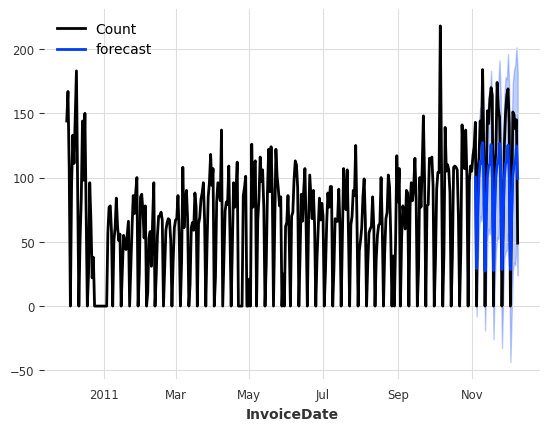

In [26]:
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

### Deep Learning Model

In [22]:
from darts.models import NBEATSModel

from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

mlflow.set_experiment(experiment_id="819832557478649396")
mlflow.autolog()
model = NBEATSModel(input_chunk_length=14, output_chunk_length=7, random_state=42)
model.fit(train_scaled, epochs=50, verbose=True);

2024/10/04 02:28:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/10/04 02:28:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2024/10/04 02:28:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/04 02:28:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/10/04 02:28:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/04 02:28:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024/10/04 02:28:33

Epoch 0: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s, train_loss=0.0377]

2024/10/04 02:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s, train_loss=0.0202]

2024/10/04 02:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s, train_loss=0.0199]

2024/10/04 02:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, train_loss=0.0119]

2024/10/04 02:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, train_loss=0.0175]

2024/10/04 02:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s, train_loss=0.0175]

2024/10/04 02:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s, train_loss=0.0162]

2024/10/04 02:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, train_loss=0.0139]

2024/10/04 02:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s, train_loss=0.0146]

2024/10/04 02:28:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s, train_loss=0.0129]

2024/10/04 02:28:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, train_loss=0.0123]

2024/10/04 02:28:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s, train_loss=0.0136]

2024/10/04 02:28:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s, train_loss=0.0126]

2024/10/04 02:28:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 13: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s, train_loss=0.0103]

2024/10/04 02:29:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s, train_loss=0.0155] 

2024/10/04 02:29:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, train_loss=0.0121] 

2024/10/04 02:29:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, train_loss=0.0139]

2024/10/04 02:29:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s, train_loss=0.0115]

2024/10/04 02:29:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s, train_loss=0.00992]

2024/10/04 02:29:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, train_loss=0.00884]

2024/10/04 02:29:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 20: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, train_loss=0.0102] 

2024/10/04 02:29:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 21: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, train_loss=0.00867]

2024/10/04 02:29:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 22: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, train_loss=0.0122] 

2024/10/04 02:29:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 23: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, train_loss=0.0133] 

2024/10/04 02:29:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 24: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, train_loss=0.0124] 

2024/10/04 02:29:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 25: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s, train_loss=0.00933]

2024/10/04 02:29:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s, train_loss=0.00824]

2024/10/04 02:29:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s, train_loss=0.0101] 

2024/10/04 02:29:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s, train_loss=0.0121] 

2024/10/04 02:29:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s, train_loss=0.00888]

2024/10/04 02:29:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 30: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s, train_loss=0.00879]

2024/10/04 02:29:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 31: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s, train_loss=0.00564]

2024/10/04 02:29:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 32: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, train_loss=0.00506]

2024/10/04 02:29:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 33: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s, train_loss=0.00763]

2024/10/04 02:29:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 34: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s, train_loss=0.00853]

2024/10/04 02:29:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s, train_loss=0.00706]

2024/10/04 02:29:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 36: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, train_loss=0.00791]

2024/10/04 02:29:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, train_loss=0.00595]

2024/10/04 02:29:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 38: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s, train_loss=0.00688]

2024/10/04 02:29:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, train_loss=0.00712]

2024/10/04 02:29:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 40: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s, train_loss=0.00738]

2024/10/04 02:29:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 41: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, train_loss=0.00528]

2024/10/04 02:29:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 42: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s, train_loss=0.00477]

2024/10/04 02:30:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 43: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s, train_loss=0.00656]

2024/10/04 02:30:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 44: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, train_loss=0.0054] 

2024/10/04 02:30:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 45: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s, train_loss=0.00679]

2024/10/04 02:30:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 46: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s, train_loss=0.00459]

2024/10/04 02:30:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 47: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, train_loss=0.00543]

2024/10/04 02:30:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 48: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s, train_loss=0.00604]

2024/10/04 02:30:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s, train_loss=0.00539]

2024/10/04 02:30:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s, train_loss=0.00539]


2024/10/04 02:30:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmprpwab0tu/model/data, flavor: pytorch). Fall back to return ['torch==2.4.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 02:30:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/envs/aistudio/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/10/04 02:30:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


<Axes: xlabel='InvoiceDate'>

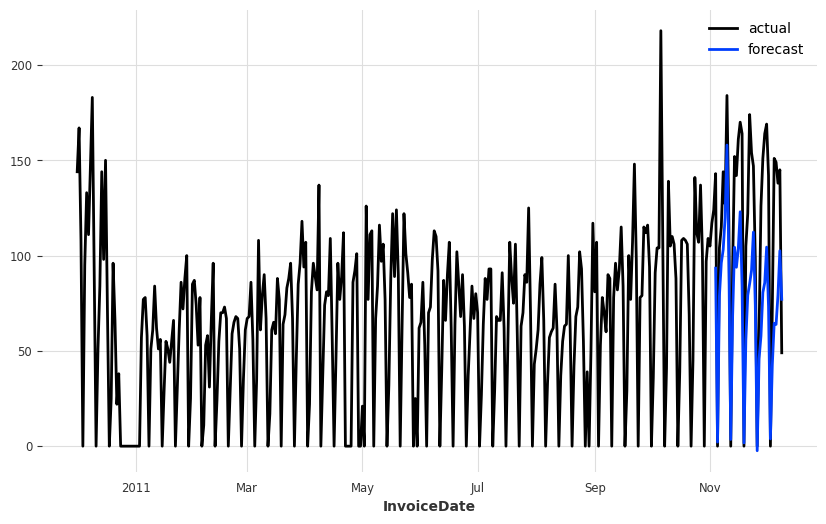

In [23]:
preds = model.predict(series=train_scaled, n=36)

# scale back:
preds = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series.plot(label="actual")
preds.plot(label="forecast")